In [11]:
# Import necessary packages and suppress warnings


import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns
import warnings
import gzip
import json
import os
import time
import math
import requests

#modeling packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn import metrics 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImPipeline


warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('EPL_data_featured.csv')
df.head()

,week,date,home_team,home_xg,score,away_xg,away_team,referee,game_id,home_team_elo,...,home_goals_conceded_to_date,away_goals_conceded_to_date,home_match_points,away_match_points,home_points_to_date,away_points_to_date,match_points,home_form,away_form,match_result
0,1,2017-08-11,arsenal,2.5,4-3,1.5,leicester city,Mike Dean,e3c3ddf0,1848.286499,...,0,0,3,0,0,0,3,0.0,0.0,0
1,1,2017-08-12,brighton,0.3,0-2,1.9,manchester city,Michael Oliver,072bfc99,1583.799805,...,0,0,0,3,0,0,3,0.0,0.0,2
2,1,2017-08-12,chelsea,1.5,2-3,0.6,burnley,Craig Pawson,71b00bca,1909.399658,...,0,0,0,3,0,0,3,0.0,0.0,2
3,1,2017-08-12,crystal palace,1.1,0-3,1.5,huddersfield,Jonathan Moss,2d369d17,1642.862427,...,0,0,0,3,0,0,3,0.0,0.0,2
4,1,2017-08-12,everton,0.6,1-0,0.4,stoke city,Niel Swarbrick,7c834541,1751.501343,...,0,0,3,0,0,0,3,0.0,0.0,0


In [13]:
df['referee'].value_counts()

referee
Anthony Taylor       177
Michael Oliver       176
Craig Pawson         143
Paul Tierney         143
Martin Atkinson      141
Andre Marriner       135
Mike Dean            132
Jonathan Moss        131
Stuart Attwell       124
Chris Kavanagh       118
Kevin Friend         116
David Coote           90
Graham Scott          87
Simon Hooper          76
Andy Madley           70
Lee Mason             64
Peter Bankes          60
Robert Jones          48
Darren England        45
Lee Probert           32
Roger East            28
Jarred Gillett        26
John Brooks           23
Niel Swarbrick        20
Robert Madley         19
Michael Salisbury     18
Mike Jones            12
Tony Harrington        9
Thomas Bramall         8
Darren Bond            4
Tim Robinson           3
Oliver Langford        1
Joshua Smith           1
Name: count, dtype: int64

In [4]:
df.columns

Index(['week', 'date', 'home_team', 'home_xg', 'score', 'away_xg', 'away_team',
       'referee', 'game_id', 'home_team_elo', 'away_team_elo', 'season',
       'home_starters', 'away_starters', 'home_xG_to_date', 'away_xG_to_date',
       'home_xG_against_to_date', 'away_xG_against_to_date',
       'home_goals_scored', 'away_goals_scored', 'home_goals_scored_to_date',
       'away_goals_scored_to_date', 'home_goals_conceded_to_date',
       'away_goals_conceded_to_date', 'home_match_points', 'away_match_points',
       'home_points_to_date', 'away_points_to_date', 'match_points',
       'home_form', 'away_form', 'match_result'],
      dtype='object')

In [5]:
# List of non-numeric/data-leakage/irrelevant-to-modeling columns to drop
columns_to_drop = ['home_team', 'away_team', 'referee', 'date', 'season', 'home_starters',
                    'away_starters', 'week', 'score', 'game_id', 'season',
                  'home_match_points', 'away_match_points', 'match_points',
                   'home_goals_scored', 'away_goals_scored',
                  'home_xg', 'away_xg']  # Add other non-numeric column names

# Drop the non-numeric columns
df_numeric = df.drop(columns=columns_to_drop)

# Now df_dropped contains only the numeric columns along with the rest of the non-listed columns


In [6]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   home_team_elo                2280 non-null   float64
 1   away_team_elo                2280 non-null   float64
 2   home_xG_to_date              2280 non-null   float64
 3   away_xG_to_date              2280 non-null   float64
 4   home_xG_against_to_date      2280 non-null   float64
 5   away_xG_against_to_date      2280 non-null   float64
 6   home_goals_scored_to_date    2280 non-null   int64  
 7   away_goals_scored_to_date    2280 non-null   int64  
 8   home_goals_conceded_to_date  2280 non-null   int64  
 9   away_goals_conceded_to_date  2280 non-null   int64  
 10  home_points_to_date          2280 non-null   int64  
 11  away_points_to_date          2280 non-null   int64  
 12  home_form                    2280 non-null   float64
 13  away_form         

In [7]:
df_numeric

,home_team_elo,away_team_elo,home_xG_to_date,away_xG_to_date,home_xG_against_to_date,away_xG_against_to_date,home_goals_scored_to_date,away_goals_scored_to_date,home_goals_conceded_to_date,away_goals_conceded_to_date,home_points_to_date,away_points_to_date,home_form,away_form,match_result
0,1848.286499,1716.994873,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0
1,1583.799805,1866.807007,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
2,1909.399658,1628.988403,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
3,1642.862427,1475.799316,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
4,1751.501343,1662.613770,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,1698.783569,1662.989624,44.3,37.8,65.2,62.7,33,37,57,70,33,39,1.0,1.2,0
2276,1664.983643,1802.854126,46.0,55.1,64.9,48.0,47,66,74,62,31,57,0.4,0.8,2
2277,1713.210815,1776.454712,49.1,47.8,62.0,51.6,49,41,67,53,31,40,0.6,1.2,0
2278,1866.215576,1736.953369,64.6,44.5,48.5,60.8,56,54,42,51,72,52,1.8,1.4,0


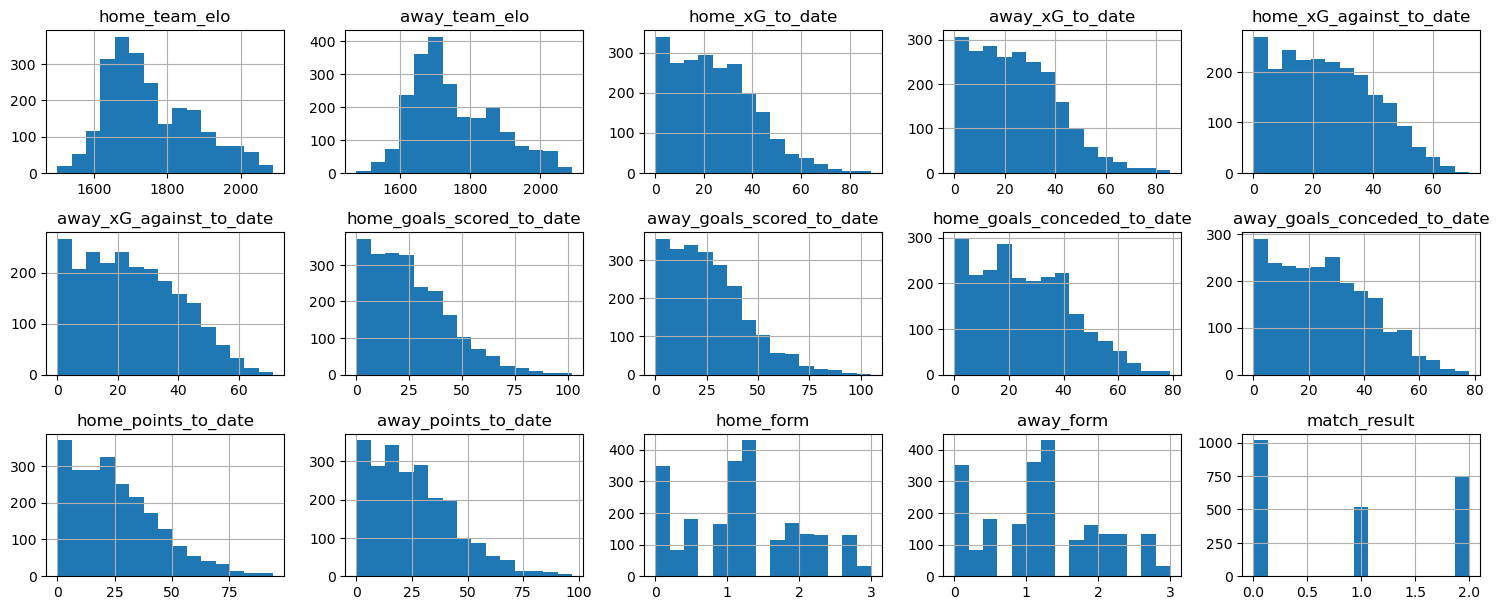

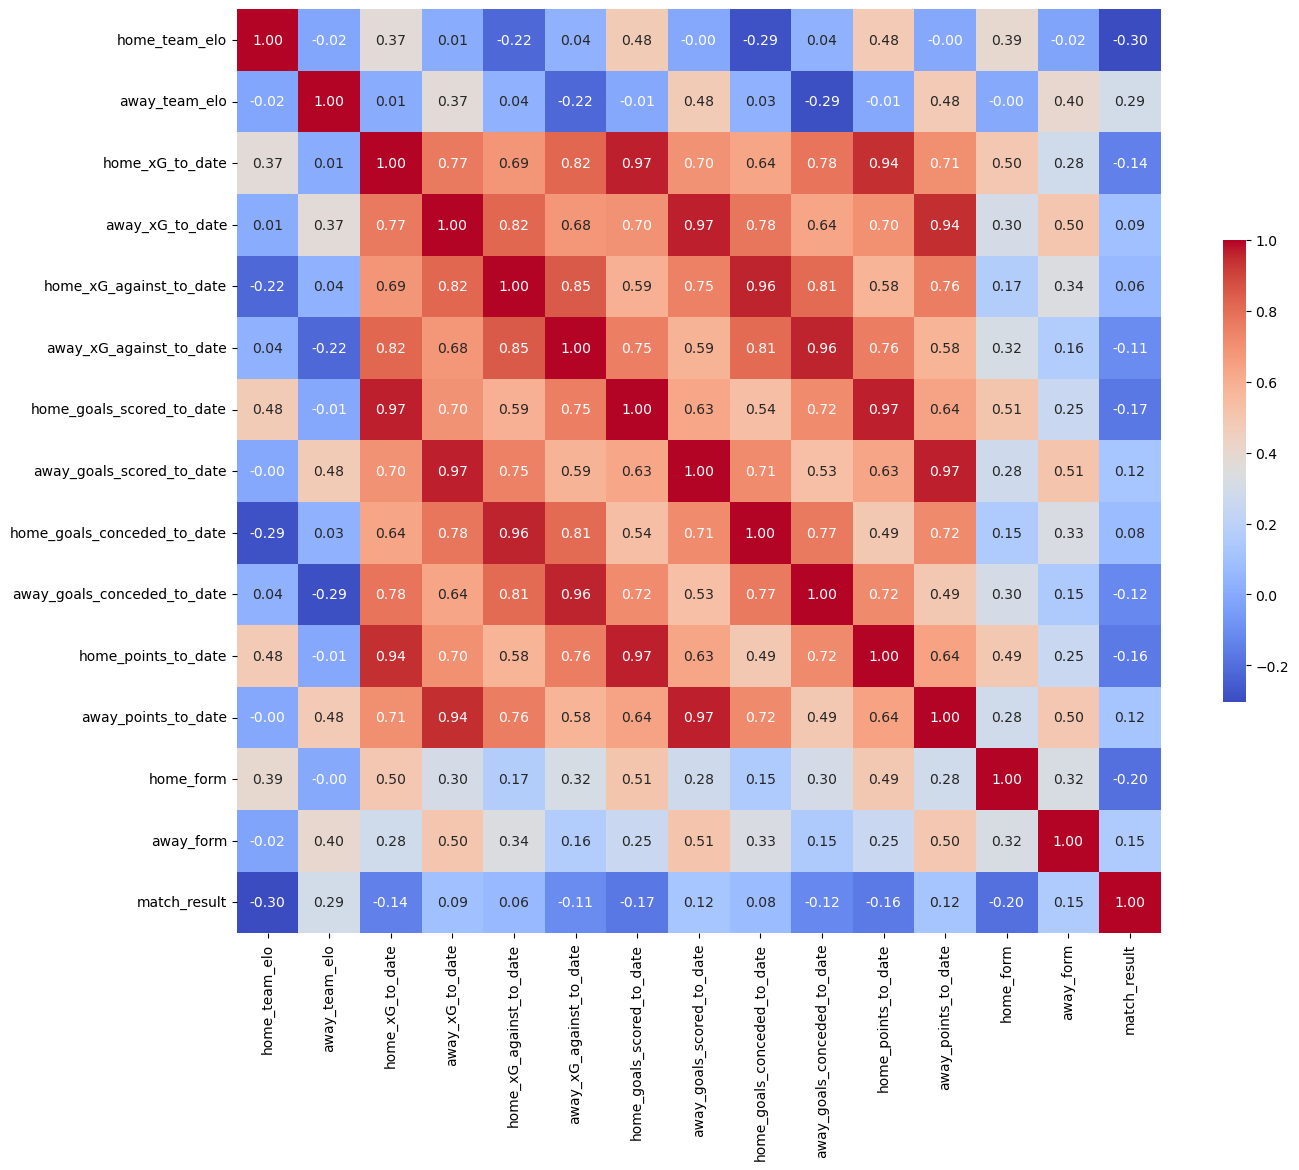

match_result
0    0.446053
2    0.325877
1    0.228070
Name: proportion, dtype: float64


In [8]:

# Assuming df_numeric is your DataFrame with only numeric columns

# Distribution of variables
df_numeric.hist(bins=15, figsize=(15, 10), layout=(5, 5))  # Adjust layout based on the number of numerical columns
plt.tight_layout()
plt.show()

# Correlations
plt.figure(figsize=(16, 12))  # Increase the size as needed
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .5})
plt.xticks(rotation=90)  # Rotate the x labels to prevent overlapping
plt.yticks(rotation=0)  # Adjust rotation as needed
plt.show()

# Target variable analysis
print(df_numeric['match_result'].value_counts(normalize=True))  # To check balance of classes


In [10]:
df_numeric.to_csv('numeric_df.csv', index=False)